# MCMC FULL PROJECT IN ONE CELL
# -------------------------------------------------------------
# Title: "Markov Chain Monte Carlo (MCMC) – From Theory to Practice"
#
# This single cell implements a complete MCMC mini–framework and
# demonstrates it on several examples:
#
# 1. Core Metropolis–Hastings sampler (general-purpose MCMC engine).
# 2. Sampling from a 1D multimodal distribution (mixture of Gaussians).
# 3. Bayesian inference for a coin’s bias (posterior sampling) and
#    comparison with the exact Beta posterior.
# 4. Sampling from a 2D correlated Gaussian target.
# 5. Diagnostics and visualization:
#    - Trace plots
#    - Histograms of samples vs true density
#    - Autocorrelation
#    - Simple Effective Sample Size (ESS) approximation
#
# The code is intentionally written as a teaching lab: readable,
# modular, and easy to extend to other problems.
# -------------------------------------------------------------


In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

In [3]:
# ============================================================
# 1. GENERIC METROPOLIS–HASTINGS SAMPLER
# ============================================================

def metropolis_hastings(
    log_target,
    x0,
    n_samples=10_000,
    proposal_std=1.0,
    burn_in=1_000,
    thinning=1,
    rng=None
):
    """
    Generic Metropolis–Hastings sampler for R^d (d = dimension of x).

    Parameters
    ----------
    log_target : callable
        Function that returns log p(x) up to a constant (unnormalized log-density).
        Signature: log_target(x) where x is a 1D numpy array or scalar.
    x0 : float or np.ndarray
        Initial state (scalar or 1D vector).
    n_samples : int
        Number of kept samples (after burn-in and thinning).
    proposal_std : float or np.ndarray
        Standard deviation(s) of Gaussian proposal q(x' | x) = N(x, proposal_std^2).
        For multivariate, can be scalar (isotropic) or 1D array for each dimension.
    burn_in : int
        Number of initial iterations to discard.
    thinning : int
        Keep 1 of every `thinning` samples after burn-in.
    rng : np.random.Generator
        Optional random number generator.

    Returns
    -------
    samples : np.ndarray, shape (n_samples, dim)
        MCMC samples from approximate target.
    acceptance_rate : float
        Ratio of accepted proposals.
    """

    if rng is None:
        rng = np.random.default_rng()

    x_current = np.array(x0, dtype=float)
    dim = x_current.shape[0] if x_current.ndim > 0 else 1

    # Convenience: handle scalar case as 1D vector, flatten later
    def as_vec(x):
        x = np.array(x, dtype=float)
        if x.ndim == 0:
            x = x[None]
        return x

    x_current = as_vec(x_current)
    logp_current = log_target(x_current)

    total_iters = burn_in + n_samples * thinning
    samples = []
    accepts = 0

    proposal_std_vec = as_vec(proposal_std)
    if proposal_std_vec.size == 1:
        proposal_std_vec = np.repeat(proposal_std_vec, dim)

    for it in range(total_iters):
        # Propose new point from Gaussian centered at current
        proposal = x_current + rng.normal(loc=0.0, scale=proposal_std_vec, size=dim)
        logp_proposal = log_target(proposal)

        # Metropolis acceptance step
        log_alpha = logp_proposal - logp_current
        if np.log(rng.uniform()) < log_alpha:
            x_current = proposal
            logp_current = logp_proposal
            accepts += 1

        # Store after burn-in and honoring thinning
        if it >= burn_in and ((it - burn_in) % thinning == 0):
            samples.append(x_current.copy())

    samples = np.array(samples)
    if dim == 1:
        samples = samples[:, 0]  # back to 1D

    acceptance_rate = accepts / total_iters
    return samples, acceptance_rate

In [4]:
# ============================================================
# 2. UTILS: AUTOCORRELATION AND EFFECTIVE SAMPLE SIZE
# ============================================================

def autocorrelation(x, max_lag=100):
    """
    Compute sample autocorrelation for lags 0..max_lag.
    """
    x = np.asarray(x)
    x = x - x.mean()
    n = len(x)
    result = np.correlate(x, x, mode="full")
    acf = result[result.size // 2:] / result[result.size // 2]
    return acf[:max_lag+1]


def effective_sample_size(x, max_lag=200):
    """
    Very simple ESS approximation:
      ESS ≈ N / (1 + 2 * sum_{k=1}^K rho_k)
    where rho_k is autocorrelation at lag k.
    """
    x = np.asarray(x)
    n = len(x)
    acf = autocorrelation(x, max_lag=max_lag)
    # stop when acf becomes negative
    positive_acf = acf[1:][acf[1:] > 0]
    tau = 1 + 2 * positive_acf.sum()
    return n / tau

=== Example 1: 1D Mixture of Gaussians ===
Acceptance rate: 0.7035882352941176
Sample mean:     1.1658886267622033
Sample std:      2.707845209657623
ESS (approx):    156.08963950358765



/tmp/ipython-input-535331652.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_grid = p_grid / np.trapz(p_grid, x_grid)


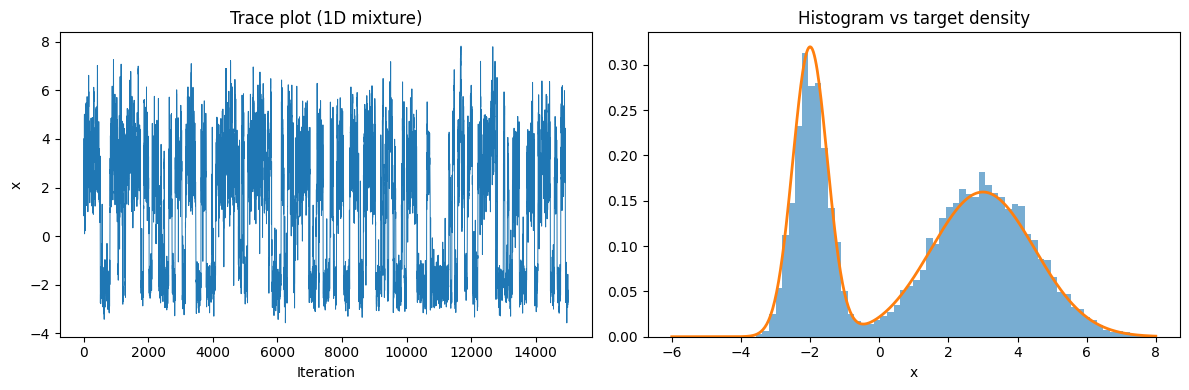

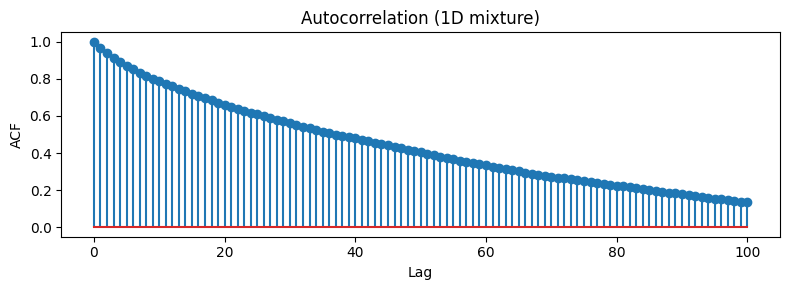

In [6]:
# ============================================================
# 3. EXAMPLE 1 – SAMPLING FROM A MULTIMODAL 1D TARGET
# ------------------------------------------------------------
# Target: mixture of two Gaussians:
#   p(x) = 0.4 * N(-2, 0.5^2) + 0.6 * N(3, 1.5^2)
# We only need log p(x) up to a constant.
# ============================================================

def log_mixture_gaussians(x):
    x = np.asarray(x)
    mu1, sigma1, w1 = -2.0, 0.5, 0.4
    mu2, sigma2, w2 =  3.0, 1.5, 0.6

    def log_gaussian(x, mu, sigma):
        return -0.5 * ((x - mu)/sigma)**2 - np.log(sigma * np.sqrt(2*np.pi))

    logp1 = np.log(w1) + log_gaussian(x, mu1, sigma1)
    logp2 = np.log(w2) + log_gaussian(x, mu2, sigma2)
    # log-sum-exp for numerical stability
    max_log = np.maximum(logp1, logp2)
    return max_log + np.log(np.exp(logp1 - max_log) + np.exp(logp2 - max_log))


# Run MCMC
rng = np.random.default_rng(123)
samples_1d, acc_1d = metropolis_hastings(
    log_target=log_mixture_gaussians,
    x0=np.array([0.0]),
    n_samples=15_000,
    proposal_std=1.0,
    burn_in=2_000,
    thinning=1,
    rng=rng
)

ess_1d = effective_sample_size(samples_1d)

print("=== Example 1: 1D Mixture of Gaussians ===")
print("Acceptance rate:", acc_1d)
print("Sample mean:    ", samples_1d.mean())
print("Sample std:     ", samples_1d.std())
print("ESS (approx):   ", ess_1d)
print()

# Plot trace and histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(samples_1d, linewidth=0.7)
axes[0].set_title("Trace plot (1D mixture)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("x")

# histogram + true density curve
x_grid = np.linspace(-6, 8, 500)
logp_grid = log_mixture_gaussians(x_grid)
p_grid = np.exp(logp_grid - logp_grid.max())  # normalized up to unknown constant; rescale
p_grid = p_grid / np.trapz(p_grid, x_grid)

axes[1].hist(samples_1d, bins=60, density=True, alpha=0.6)
axes[1].plot(x_grid, p_grid, linewidth=2)
axes[1].set_title("Histogram vs target density")
axes[1].set_xlabel("x")

plt.tight_layout()
plt.show()

# Autocorrelation
acf_1d = autocorrelation(samples_1d, max_lag=100)
plt.figure(figsize=(8,3))
plt.stem(range(len(acf_1d)), acf_1d)
plt.title("Autocorrelation (1D mixture)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

In [7]:
# ============================================================
# 4. EXAMPLE 2 – BAYESIAN COIN BIAS INFERENCE (BETA-BERNOULLI)
# ------------------------------------------------------------
# Prior: theta ~ Beta(a, b)
# Observations: x_i ~ Bernoulli(theta)
#
# Posterior analytically: Beta(a + sum x_i, b + n - sum x_i)
#
# We will:
#   1. Simulate coin flips.
#   2. Define log-posterior up to constant.
#   3. Use MCMC to sample theta.
#   4. Compare histogram vs exact Beta posterior.
# ============================================================

# Generate synthetic data
true_theta = 0.7
n_flips = 80
data = rng.binomial(1, true_theta, size=n_flips)
sum_x = data.sum()

a_prior, b_prior = 2.0, 2.0
a_post = a_prior + sum_x
b_post = b_prior + n_flips - sum_x

def log_beta_posterior(theta):
    # log p(theta | data) ∝ (a_post - 1)*log(theta) + (b_post - 1)*log(1-theta)
    # domain: 0 < theta < 1
    theta = np.asarray(theta)
    # Reject theta outside (0,1) by returning -inf
    if np.any(theta <= 0) or np.any(theta >= 1):
        return -np.inf
    return (a_post - 1)*np.log(theta) + (b_post - 1)*np.log(1 - theta)

samples_theta, acc_theta = metropolis_hastings(
    log_target=log_beta_posterior,
    x0=np.array([0.5]),
    n_samples=10_000,
    proposal_std=0.1,
    burn_in=1_000,
    thinning=1,
    rng=rng
)

ess_theta = effective_sample_size(samples_theta)

print("=== Example 2: Bayesian Coin Bias ===")
print("True theta:      ", true_theta)
print("Posterior Beta:   a_post =", a_post, ", b_post =", b_post)
print("MCMC mean(theta):", samples_theta.mean())
print("MCMC std(theta): ", samples_theta.std())
print("Acceptance rate: ", acc_theta)
print("ESS (approx):    ", ess_theta)
print()

=== Example 2: Bayesian Coin Bias ===
True theta:       0.7
Posterior Beta:   a_post = 53.0 , b_post = 31.0
MCMC mean(theta): 0.630718697320812
MCMC std(theta):  0.051880462766777505
Acceptance rate:  0.518
ESS (approx):     1490.2573637426033



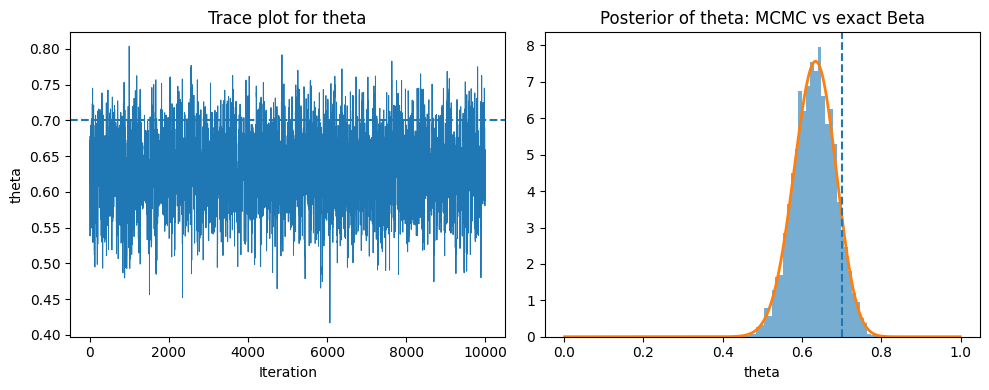

In [8]:
# Plot histogram vs exact Beta density
from math import gamma

def beta_pdf(x, a, b):
    B = gamma(a) * gamma(b) / gamma(a + b)
    return x**(a-1) * (1-x)**(b-1) / B

theta_grid = np.linspace(0.001, 0.999, 400)
beta_density = beta_pdf(theta_grid, a_post, b_post)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(samples_theta, linewidth=0.7)
plt.axhline(true_theta, linestyle="--")
plt.title("Trace plot for theta")
plt.xlabel("Iteration")
plt.ylabel("theta")

plt.subplot(1,2,2)
plt.hist(samples_theta, bins=40, density=True, alpha=0.6)
plt.plot(theta_grid, beta_density, linewidth=2)
plt.axvline(true_theta, linestyle="--")
plt.title("Posterior of theta: MCMC vs exact Beta")
plt.xlabel("theta")
plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# 5. EXAMPLE 3 – 2D TARGET: CORRELATED GAUSSIAN
# ------------------------------------------------------------
# Target: 2D Gaussian with mean [0,0] and covariance
#   [[1.0, 0.8],
#    [0.8, 1.5]]
# ============================================================

mu_2d = np.array([0.0, 0.0])
Sigma_2d = np.array([[1.0, 0.8],
                     [0.8, 1.5]])
Sigma_inv_2d = np.linalg.inv(Sigma_2d)
log_det_Sigma_2d = np.log(np.linalg.det(Sigma_2d))

def log_gaussian_2d(x):
    x = np.asarray(x)
    diff = x - mu_2d
    return -0.5 * (diff @ Sigma_inv_2d @ diff) - 0.5 * log_det_Sigma_2d - np.log(2*np.pi)

samples_2d, acc_2d = metropolis_hastings(
    log_target=log_gaussian_2d,
    x0=np.array([3.0, -3.0]),
    n_samples=12_000,
    proposal_std=np.array([0.7, 0.7]),
    burn_in=2_000,
    thinning=1,
    rng=rng
)

print("=== Example 3: 2D Correlated Gaussian ===")
print("Acceptance rate:", acc_2d)
print("Sample mean:\n", samples_2d.mean(axis=0))
print("Sample covariance:\n", np.cov(samples_2d.T))
print()

=== Example 3: 2D Correlated Gaussian ===
Acceptance rate: 0.6284285714285714
Sample mean:
 [-0.0739 -0.0776]
Sample covariance:
 [[1.0155 0.8321]
 [0.8321 1.5787]]



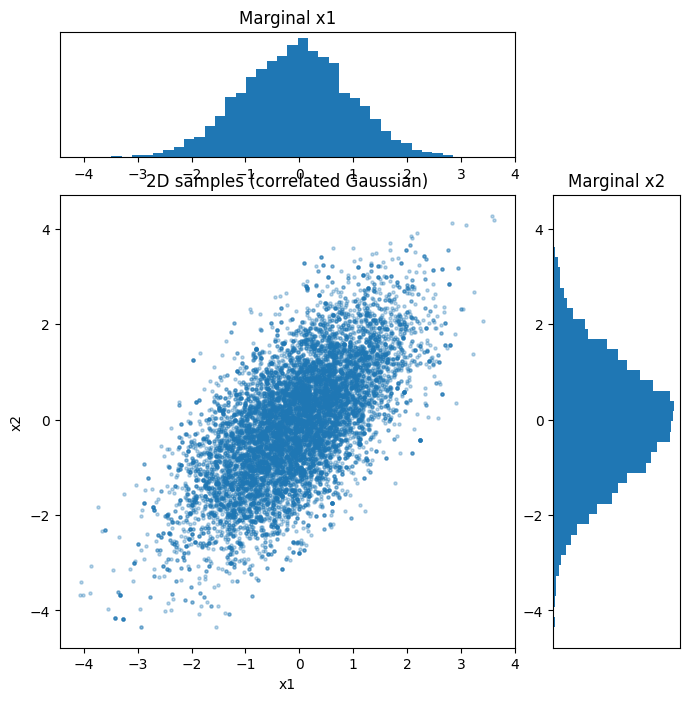

In [10]:
# 2D scatter and marginal histograms
x2, y2 = samples_2d[:,0], samples_2d[:,1]

fig = plt.figure(figsize=(8,8))
grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)

main_ax = fig.add_subplot(grid[1:4, 0:3])
y_hist_ax = fig.add_subplot(grid[1:4, 3])
x_hist_ax = fig.add_subplot(grid[0, 0:3])

main_ax.scatter(x2, y2, s=5, alpha=0.3)
main_ax.set_xlabel("x1")
main_ax.set_ylabel("x2")
main_ax.set_title("2D samples (correlated Gaussian)")

x_hist_ax.hist(x2, bins=40)
x_hist_ax.set_title("Marginal x1")
x_hist_ax.set_yticks([])

y_hist_ax.hist(y2, bins=40, orientation='horizontal')
y_hist_ax.set_title("Marginal x2")
y_hist_ax.set_xticks([])

plt.show()

In [11]:
# ============================================================
# 6. SUMMARY
# ============================================================
print("MCMC project complete:")
print("- Implemented a general Metropolis–Hastings engine.")
print("- Sampled from a multimodal 1D mixture distribution.")
print("- Performed Bayesian inference for a coin’s bias via MCMC and compared with exact Beta posterior.")
print("- Sampled from a 2D correlated Gaussian and visualized joint and marginal distributions.")
print("- Computed simple diagnostics: acceptance rates, autocorrelation, ESS.")

MCMC project complete:
- Implemented a general Metropolis–Hastings engine.
- Sampled from a multimodal 1D mixture distribution.
- Performed Bayesian inference for a coin’s bias via MCMC and compared with exact Beta posterior.
- Sampled from a 2D correlated Gaussian and visualized joint and marginal distributions.
- Computed simple diagnostics: acceptance rates, autocorrelation, ESS.
